# **GENERATING MUSIC SEQUENCE IN LSTM**

ในโปรเจกต์นี้เราจะทำการสร้างเพลงโดยการคาดเดาโน้ตตัวถัดไปของ MIDI โดยใช้ LSTM (Long Short-Term Memory) ซึ่งเป็นประเภทหนึ่งของ Recurrent Neural Network (RNN) ที่มีประสิทธิภาพในการจัดการกับข้อมูลที่มีลำดับ

## การนำเข้าไลบรารี

ก่อนอื่น เราจะต้องนำเข้าไลบรารีที่จำเป็นสำหรับโปรเจกต์นี้:

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from typing import Dict, List, Optional, Sequence, Tuple
import collections
import datetime
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi

from IPython import display
from matplotlib import pyplot as plt
import seaborn as sns


## ตั้งค่าเส้นทางและโหลดข้อมูล
ในขั้นตอนนี้ เราจะตั้งค่าเส้นทางไปยังโฟลเดอร์ที่มีไฟล์ MIDI และโหลดข้อมูลจากไฟล์เหล่านั้น
ข้อมูลที่เอามาเทรนนั้นหามาจาก tensorflow maestro กับหาเอง
https://magenta.tensorflow.org/datasets/maestro


In [3]:
# ตั้งค่าเส้นทางและโหลดข้อมูล
data_dir = pathlib.Path('data/train')

filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('จำนวนไฟล์:', len(filenames))


filetest = glob.glob(str('test/*.mid*'))
print('จำนวนไฟล์ TEST :', len(filetest))


จำนวนไฟล์: 1026
จำนวนไฟล์ TEST : 257


## วิเคราะห์และทำงานกับไฟล์ตัวอย่าง

ในขั้นตอนนี้ เราจะเลือกไฟล์ MIDI ตัวอย่างหนึ่งจากไฟล์ที่โหลดมา และทำการวิเคราะห์ข้อมูลภายในไฟล์นั้น รวมถึงการดึงข้อมูลเกี่ยวกับเครื่องดนตรีและโน้ตในไฟล์



In [4]:
# วิเคราะห์และทำงานกับไฟล์ตัวอย่าง
sample_file = filenames[1]
print(sample_file)

pm = pretty_midi.PrettyMIDI(sample_file)

print('จำนวนเครื่องดนตรี:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('ชื่อเครื่องดนตรี:', instrument_name)

# การดึงโน้ต
for i, note in enumerate(instrument.notes[:10]):
    note_name = pretty_midi.note_number_to_name(note.pitch)
    duration = note.end - note.start
    print(f'{i}: pitch={note.pitch}, note_name={note_name}, duration={duration:.4f}')


data\train\2004\MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav.midi
จำนวนเครื่องดนตรี: 1
ชื่อเครื่องดนตรี: Acoustic Grand Piano
0: pitch=31, note_name=G1, duration=0.0656
1: pitch=43, note_name=G2, duration=0.0792
2: pitch=44, note_name=G#2, duration=0.0740
3: pitch=32, note_name=G#1, duration=0.0729
4: pitch=34, note_name=A#1, duration=0.0708
5: pitch=46, note_name=A#2, duration=0.0948
6: pitch=48, note_name=C3, duration=0.6260
7: pitch=36, note_name=C2, duration=0.6542
8: pitch=53, note_name=F3, duration=1.7667
9: pitch=56, note_name=G#3, duration=1.7688


## ฟังก์ชันสำหรับดึงโน้ตจากไฟล์ MIDI

ในขั้นตอนนี้ เราจะสร้างฟังก์ชันที่ชื่อว่า `midi_to_notes` เพื่อดึงข้อมูลโน้ตจากไฟล์ MIDI และจัดเก็บข้อมูลในรูปแบบ DataFrame ของ Pandas ซึ่งจะประกอบด้วยความสูงของโน้ต เวลาเริ่ม เวลา สิ้นสุด ระยะเวลาของโน้ต และเวลาที่ผ่านไปตั้งแต่โน้ตตัวก่อนหน้า


In [5]:
# ฟังก์ชันสำหรับดึงโน้ตจากไฟล์ MIDI
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    # เรียงลำดับโน้ตตามเวลาที่เริ่มเล่น
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)        # ความสูงของโน้ต
        notes['start'].append(start)             # เวลาเริ่ม
        notes['end'].append(end)                 # เวลาสิ้นสุด
        notes['step'].append(start - prev_start) # เวลาที่ผ่านไปตั้งแต่โน้ตตัวก่อนหน้า
        notes['duration'].append(end - start)    # ระยะเวลาของโน้ต
        prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

# ดึงข้อมูลโน้ตจากไฟล์ตัวอย่าง
raw_notes = midi_to_notes(sample_file)
raw_notes.head()


,pitch,start,end,step,duration
0,43,1.032292,1.111458,0.000000,0.079167
1,31,1.040625,1.106250,0.008333,0.065625
2,44,1.142708,1.216667,0.102083,0.073958
3,32,1.144792,1.217708,0.002083,0.072917
4,46,1.208333,1.303125,0.063542,0.094792


## การแสดงผลข้อมูลโน้ต

ในขั้นตอนนี้ เราจะทำการแสดงผลข้อมูลโน้ตที่เราได้จากฟังก์ชัน `midi_to_notes` โดยใช้ `matplotlib` เพื่อสร้างกราฟ แสดงความสูงของโน้ต (Pitch), เวลา (Step), และระยะเวลาของโน้ต (Duration) ของโน้ตที่เราได้จากไฟล์ MIDI

### การแสดงผลโน้ต 100 ตัวแรก

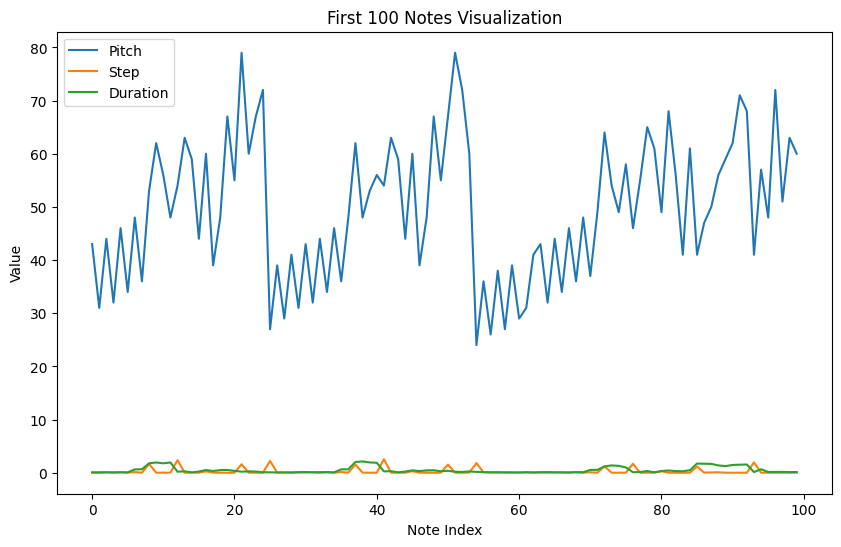

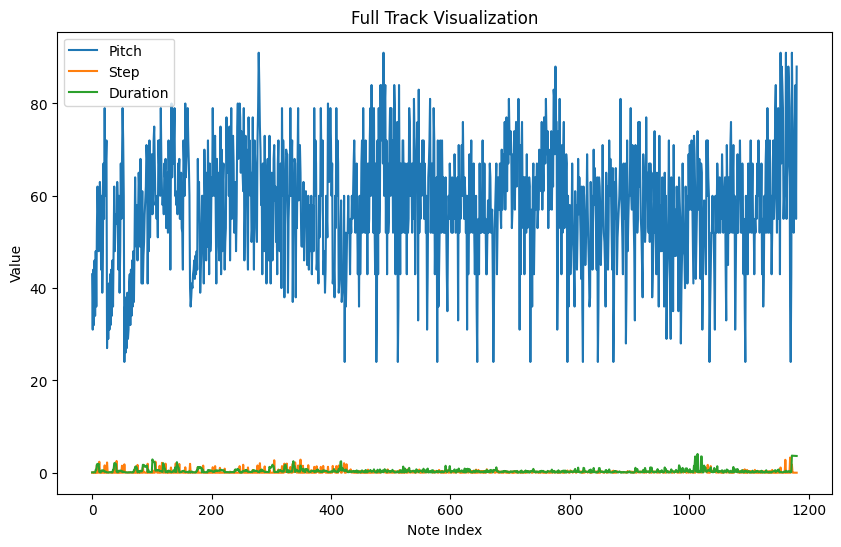

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(raw_notes['pitch'][:100], label='Pitch')
plt.plot(raw_notes['step'][:100], label='Step')
plt.plot(raw_notes['duration'][:100], label='Duration')
plt.xlabel('Note Index')
plt.ylabel('Value')
plt.title('First 100 Notes Visualization')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(raw_notes['pitch'], label='Pitch')
plt.plot(raw_notes['step'], label='Step')
plt.plot(raw_notes['duration'], label='Duration')
plt.xlabel('Note Index')
plt.ylabel('Value')
plt.title('Full Track Visualization')
plt.legend()
plt.show()


## แปลงค่า Pitch ให้เป็นชื่อโน้ต

ในขั้นตอนนี้ เราจะทำการแปลงค่า pitch ที่เราได้จากไฟล์ MIDI ให้เป็นชื่อโน้ต โดยใช้ฟังก์ชัน `pretty_midi.note_number_to_name` เพื่อให้สามารถระบุชื่อโน้ตได้ง่ายขึ้น



In [7]:
# แปลงค่า pitch ให้เป็นชื่อโน้ต
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])

# แสดงชื่อโน้ตตัวอย่าง 10 ตัวแรก
print(sample_note_names[:10])


['G2' 'G1' 'G#2' 'G#1' 'A#2' 'A#1' 'C3' 'C2' 'F3' 'D4']


## ฟังก์ชันสำหรับสร้างพล็อต Piano Roll

ในขั้นตอนนี้ เราจะสร้างฟังก์ชัน `plot_piano_roll` เพื่อพล็อตโน้ตในรูปแบบ Piano Roll ซึ่งช่วยให้เราสามารถเห็นโน้ตที่เล่นในช่วงเวลาต่าง ๆ ได้อย่างชัดเจน โดยกราฟจะแสดงความสูงของโน้ต (Pitch) กับเวลา


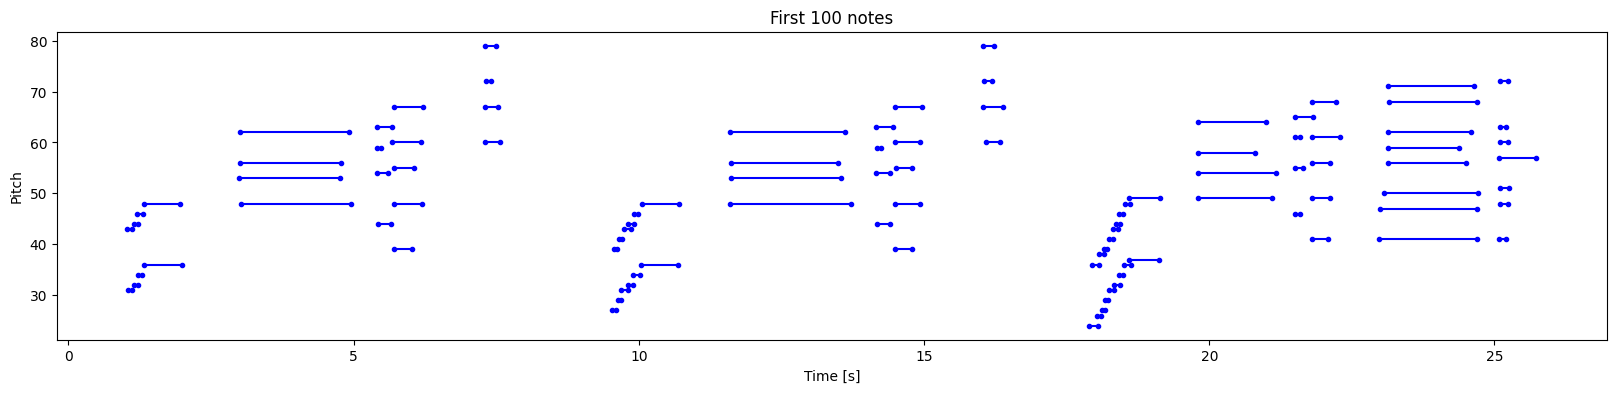

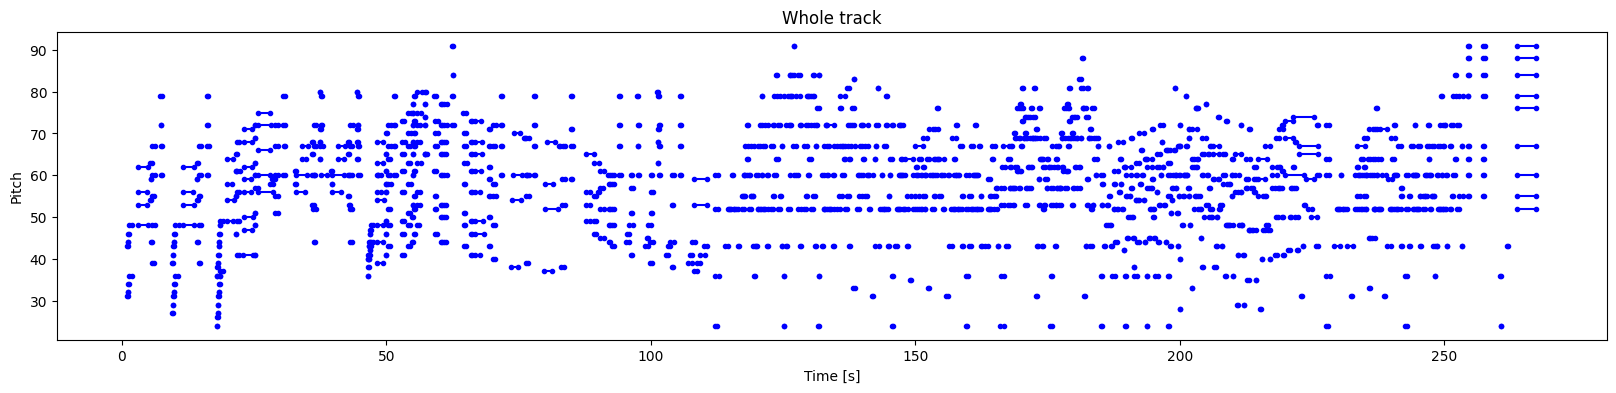

In [8]:

def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
    if count:
        title = f'First {count} notes'
    else:
        title = 'Whole track'
        count = len(notes['pitch'])
        
    plt.figure(figsize=(20, 4))
    
    # เตรียมข้อมูล pitch และเวลา start/end สำหรับการพล็อต
    plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
    plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
    
    # พล็อตข้อมูลโน้ต
    plt.plot(plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
    plt.xlabel('Time [s]')
    plt.ylabel('Pitch')
    plt.title(title)
    plt.show()

# แสดงพล็อตโน้ต 100 ตัวแรก
plot_piano_roll(raw_notes, count=100)

# แสดงพล็อตโน้ตทั้งเพลง
plot_piano_roll(raw_notes)

## รวมโน้ตจากหลายไฟล์ MIDI และสร้าง TensorFlow Dataset

ในขั้นตอนนี้ เราจะทำการอ่านไฟล์ MIDI หลายไฟล์และรวมโน้ตทั้งหมดใน DataFrame เดียว จากนั้นเราจะสร้าง TensorFlow dataset สำหรับการฝึกโมเดล


In [9]:
num_files = 5  # จำนวนไฟล์ที่จะนำมาประมวลผล
all_notes = []

# อ่านโน้ตจากไฟล์ MIDI และเก็บไว้ใน list
for f in filenames[:num_files]:
    notes = midi_to_notes(f)
    all_notes.append(notes)

# รวมโน้ตทั้งหมดเป็น DataFrame เดียว
all_notes = pd.concat(all_notes)

n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

# สร้างเวกเตอร์ของ pitch, step, และ duration
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

# สร้าง tf.data.Dataset
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

Number of notes parsed: 37241


TensorSpec(shape=(3,), dtype=tf.float64, name=None)

## สร้าง Sequences จาก TensorFlow Dataset

ในขั้นตอนนี้ เราจะสร้างฟังก์ชัน `create_sequences` ซึ่งจะช่วยในการสร้าง sequences จาก TensorFlow dataset เพื่อใช้ในการฝึกโมเดล LSTM โดยเราจะใช้ความยาวของ sequence ที่กำหนดไว้ และแบ่งข้อมูลออกเป็น input และ label


In [10]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size=128,
) -> tf.data.Dataset:
    seq_length = seq_length + 1  # เพิ่มความยาว 1 เพื่อใช้ในการสร้าง label
    windows = dataset.window(seq_length, shift=1, stride=1, drop_remainder=True)
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows.flat_map(flatten)

    def scale_pitch(x):
        x = x / [vocab_size, 1.0, 1.0]  # สเกลค่า pitch
        return x

    def split_labels(sequences):
        inputs = sequences[:-1]  # ข้อมูล input
        labels_dense = sequences[-1]  # ข้อมูล label
        labels = {key: labels_dense[i] for i, key in enumerate(key_order)}

        return scale_pitch(inputs), labels

    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

# กำหนดความยาวของ sequence
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)

## เตรียม Training Dataset สำหรับการฝึกโมเดล LSTM

ในขั้นตอนนี้ เราจะกำหนด batch size และ buffer size เพื่อเตรียมข้อมูลสำหรับการฝึกโมเดล LSTM โดยใช้ TensorFlow dataset ที่เราสร้างขึ้นก่อนหน้านี้



In [22]:
# กำหนด batch size
batch_size = 64
buffer_size = n_notes - seq_length  # จำนวนข้อมูลใน dataset

# เตรียม training dataset
train_ds = (seq_ds
            .shuffle(buffer_size)  # สุ่มข้อมูล
            .batch(batch_size, drop_remainder=True)  # แบ่งข้อมูลเป็น batch
            .cache()  # แคชข้อมูลเพื่อให้โหลดเร็วขึ้น
            .prefetch(tf.data.experimental.AUTOTUNE))  # โหลดข้อมูลล่วงหน้า

## ฟังก์ชัน MSE ที่รวมแรงกดดันเชิงบวก

ในขั้นตอนนี้ เราจะสร้างฟังก์ชัน `mse_with_positive_pressure` เพื่อใช้ในการคำนวณค่า Mean Squared Error (MSE) ที่รวมกับแรงกดดันเชิงบวก เพื่อเพิ่มความสำคัญในการลดค่าที่ต่ำกว่าศูนย์ในการคาดการณ์


In [23]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
    mse = (y_true - y_pred) ** 2  # คำนวณค่า MSE
    positive_pressure = 10 * tf.maximum(-y_pred, 0.0)  # คำนวณแรงกดดันเชิงบวก
    return tf.reduce_mean(mse + positive_pressure)  # ส่งกลับค่าเฉลี่ยรวม


## สร้างและคอมไพล์โมเดล LSTM สำหรับการสร้างโน้ตเพลง

ในขั้นตอนนี้ เราจะสร้างโมเดล LSTM ที่ใช้สำหรับการคาดการณ์โน้ตเพลง โดยโมเดลนี้จะมีการคำนวณการสูญเสีย (loss) ที่แตกต่างกันสำหรับโน้ตเสียง (pitch), เวลาที่ผ่านไป (step), และระยะเวลา (duration)


In [68]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

model = Model(inputs=inputs, outputs=outputs, name="model")

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 25, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_17 (LSTM)      │ (None, 128)       │     67,584 │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration (Dense)    │ (None, 1)         │        129 │ lstm_17[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pitch (Dense)       │ (None, 128)       │     16,512 │ lstm_17[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ step (Dense)        │ (None, 1)         │        129 │ lstm_17[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,354 (329.51 KB)

 Trainable params: 84,354 (329.51 KB)

 Non-trainable params: 0 (0.00 B)

## สร้าง Callbacks สำหรับการฝึกอบรมโมเดล

ในขั้นตอนนี้ เราจะสร้าง callbacks ที่จำเป็นสำหรับการฝึกอบรมโมเดล LSTM ของเรา Callbacks จะช่วยในการบันทึกน้ำหนักของโมเดลในช่วงเวลาที่ดีที่สุดและหยุดการฝึกอบรมหากไม่มีการปรับปรุงในช่วงเวลาที่กำหนด


In [69]:
# Creating the necessary callbacks

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='./training_checkpoints/ckpt_{epoch}.weights.h5', save_weights_only=True),
             tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, 
                                              verbose=1, restore_best_weights=True),]


## การ Compile และ Fit โมเดล LSTM

ในขั้นตอนนี้ เราจะทำการ compile โมเดล LSTM ของเราและเริ่มต้นการฝึกอบรมโมเดล โดยระบุค่า loss และ optimizer ที่ต้องการ


In [75]:
# การ compile และ fit โมเดล

model.compile(loss = loss, 
              loss_weights = {'pitch': 0.05, 'step': 1.0, 'duration':1.0,},
              optimizer = optimizer)

epochs = 50

history = model.fit(train_ds, 
                    epochs=epochs, 
                    callbacks=callbacks,)


Epoch 1/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - duration_loss: 0.0228 - loss: 0.1956 - pitch_loss: 0.1641 - step_loss: 0.0087
Epoch 2/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - duration_loss: 0.0221 - loss: 0.1938 - pitch_loss: 0.1634 - step_loss: 0.0083
Epoch 3/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - duration_loss: 0.0236 - loss: 0.1966 - pitch_loss: 0.1639 - step_loss: 0.0091
Epoch 4/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - duration_loss: 0.0235 - loss: 0.1949 - pitch_loss: 0.1631 - step_loss: 0.0083
Epoch 5/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - duration_loss: 0.0247 - loss: 0.1972 - pitch_loss: 0.1639 - step_loss: 0.0086
Epoch 6/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - duration_loss: 0.0218 - loss: 0.1935 - pitch_loss: 0.1631 - step_loss: 0.0086
Epoch 7/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - duration_loss: 0.0212 - loss: 0.1921 - pitch_loss: 0.1626 - step_loss: 0.0082
Epoch 8/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - durati

## การวิเคราะห์ค่า Loss ของโมเดล

หลังจากที่เราได้ฝึกอบรมโมเดล LSTM ของเราแล้ว เราสามารถวิเคราะห์ค่า loss ที่เกิดขึ้นในระหว่างการฝึกอบรมได้ โดยเราจะทำการพล็อตกราฟของค่า training loss เพื่อดูแนวโน้มการลดลงของค่า loss


[0.19507353007793427, 0.193701833486557, 0.19405163824558258, 0.1927907019853592, 0.19375228881835938, 0.19163908064365387, 0.19074587523937225, 0.19278140366077423, 0.19727171957492828, 0.1953517347574234, 0.19583594799041748, 0.18922948837280273, 0.18432943522930145, 0.1829114556312561, 0.18343216180801392, 0.18411040306091309, 0.18219809234142303, 0.18103279173374176, 0.1811039298772812, 0.18702256679534912, 0.18143752217292786, 0.1840575933456421, 0.17938901484012604, 0.17893686890602112, 0.17746935784816742, 0.17686039209365845, 0.17630457878112793, 0.17744386196136475, 0.1750151664018631, 0.17317511141300201, 0.17454856634140015, 0.17572620511054993, 0.17342150211334229, 0.17219270765781403, 0.17163847386837006, 0.1720261126756668, 0.17178884148597717, 0.1722639948129654, 0.1722441464662552, 0.16999509930610657, 0.170192152261734, 0.17303898930549622, 0.16751901805400848, 0.16553093492984772, 0.1671372652053833, 0.16870397329330444, 0.17437252402305603, 0.1679384410381317, 0.1652

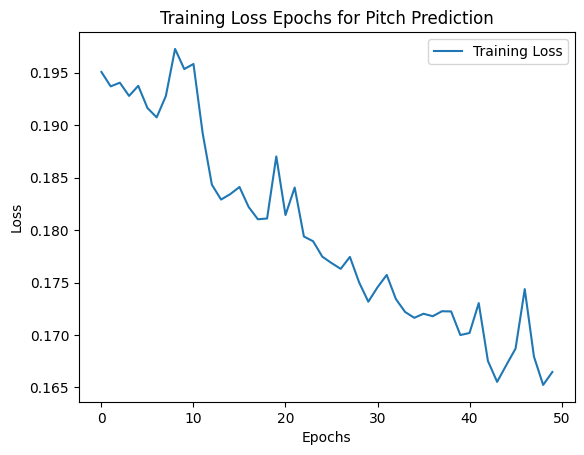

In [80]:
print(history.history['loss'])      
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss Epochs for Pitch Prediction')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## ฟังก์ชันการคาดเดาโน้ต

ฟังก์ชัน `predict_next_note` ใช้สำหรับคาดเดาโน้ตถัดไปจากโน้ตที่มีอยู่ โดยอิงจากโมเดล LSTM ที่เราได้ฝึกอบรมไว้ ฟังก์ชันนี้รับพารามิเตอร์ดังนี้:

- **notes (np.ndarray)**: โน้ตที่ใช้สำหรับการคาดเดา ควรมีรูปแบบของอาเรย์ที่มีลักษณะตามที่โมเดลกำหนด
- **keras_model (tf.keras.Model)**: โมเดลที่ถูกฝึกอบรมแล้วที่ใช้ในการคาดเดา
- **temperature (float)**: ปรับความหลากหลายของการคาดเดา ถ้าตั้งค่าเป็น 1.0 จะให้ความหลากหลายสูง ถ้าต่ำกว่าจะคาดเดาได้มั่นคงขึ้น

### โค้ดฟังก์ชัน


In [81]:
# ฟังก์ชันสำหรับคาดเดาโน้ตโดยใช้โมเดลเทรนแล้ว
def predict_next_note(notes: np.ndarray, keras_model: tf.keras.Model, temperature: float = 1.0) -> int:
    """Generates a note IDs using a trained sequence model."""

    assert temperature > 0

    # Add batch dimension
    inputs = tf.expand_dims(notes, 0)

    predictions = keras_model.predict(inputs)
    pitch_logits = predictions['pitch']
    step = predictions['step']
    duration = predictions['duration']

    pitch_logits /= temperature
    pitch = tf.random.categorical(pitch_logits, num_samples=1)
    pitch = tf.squeeze(pitch, axis=-1)
    duration = tf.squeeze(duration, axis=-1)
    step = tf.squeeze(step, axis=-1)

    # `step` and `duration` values should be non-negative
    step = tf.maximum(0, step)
    duration = tf.maximum(0, duration)

    return int(pitch), float(step), float(duration)

## โหลดไฟล์ MIDI จากโฟลเดอร์ Test

ในขั้นตอนนี้ เราจะโหลดไฟล์ MIDI ทั้งหมดจากโฟลเดอร์ `test` และแปลงข้อมูลโน้ตจากไฟล์ MIDI เหล่านั้นเป็น DataFrame โดยใช้ฟังก์ชัน `midi_to_dataframe`

### โค้ด


In [82]:
# โหลดไฟล์ MIDI ทั้งหมดจากโฟลเดอร์ test
filetest = glob.glob('test/*.mid*')
print('จำนวนไฟล์ TEST :', len(filetest))

# ฟังก์ชันสำหรับอ่านไฟล์ MIDI และแปลงเป็น DataFrame ของโน้ต
def midi_to_dataframe(midi_file):
    midi_data = pretty_midi.PrettyMIDI(midi_file)
    notes = []
    for instrument in midi_data.instruments:
        if not instrument.is_drum:  # ไม่สนใจ drum notes
            for note in instrument.notes:
                notes.append({
                    'pitch': note.pitch,
                    'start': note.start,
                    'end': note.end,
                    'step': note.start,  # สามารถเพิ่มการคำนวณ step และ duration ได้ตามต้องการ
                    'duration': note.end - note.start
                })
    return pd.DataFrame(notes)

# โหลดข้อมูลโน้ตจากโฟลเดอร์ test
all_notes = pd.DataFrame()
for midi_file in filetest:
    notes_df = midi_to_dataframe(midi_file)
    all_notes = pd.concat([all_notes, notes_df], ignore_index=True)

print(f"โน้ตทั้งหมดที่นำมาใช้จากไฟล์ใน test: {len(all_notes)}")



จำนวนไฟล์ TEST : 257
โน้ตทั้งหมดที่นำมาใช้จากไฟล์ใน test: 1431919


## ฟังก์ชันคำนวณความแม่นยำของ Pitch

ในขั้นตอนนี้ เราจะสร้างฟังก์ชันที่ใช้ในการคำนวณความแม่นยำของโน้ต pitch ที่สร้างขึ้นจากโมเดลเมื่อเปรียบเทียบกับโน้ตที่แท้จริง ฟังก์ชันนี้จะช่วยให้เราสามารถประเมินความถูกต้องของโน้ตที่สร้างขึ้นได้

### ฟังก์ชัน `calculate_pitch_accuracy`


In [83]:
# ฟังก์ชันคำนวณความแม่นยำของ pitch
def calculate_pitch_accuracy(true_note, generated_note):
    true_pitch = true_note[0]
    generated_pitch = generated_note[0]
    if true_pitch != 0:
        return max(1 - (abs(generated_pitch - true_pitch) / true_pitch), 0)
    return 0

## การสร้างโมเดลสำหรับการสร้างโน้ตจากไฟล์ MIDI

ในขั้นตอนนี้ เราจะใช้โมเดลที่ถูกฝึกเพื่อสร้างโน้ตจากไฟล์ MIDI และคำนวณความแม่นยำของ pitch สำหรับโน้ตที่สร้างขึ้นในแต่ละไฟล์

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━

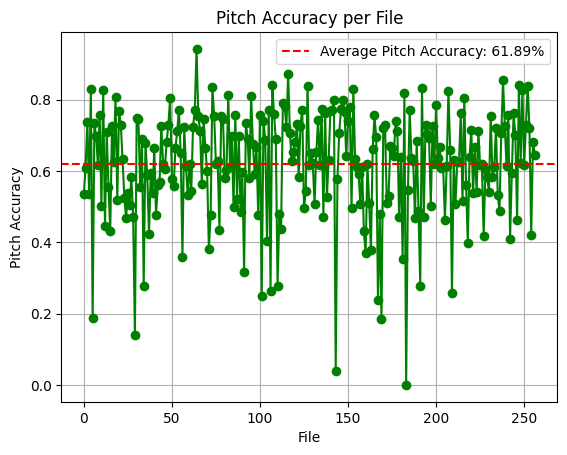

In [84]:
# ค่าพารามิเตอร์เบื้องต้น
temperature = 2.0
num_predictions = 10
seq_length = 25
vocab_size = 128
overall_pitch_accuracies = []
# เทรนโมเดลและคำนวณความแม่นยำสำหรับแต่ละไฟล์
for index, midi_file in enumerate(filetest):
    sample_notes = midi_to_dataframe(midi_file).to_numpy()  # แปลง DataFrame เป็น numpy array
    input_notes = sample_notes[:seq_length, :3] / np.array([vocab_size, 1, 1])

    generated_notes = []
    pitch_accuracies = []
    prev_start = 0

    # ลูปการคาดเดาโน้ต
    for i in range(num_predictions):
        # ใช้ฟังก์ชัน predict_next_note เพื่อทำนายโน้ตถัดไปโดยใช้โมเดลที่ถูกเทรน
        pitch, step, duration = predict_next_note(input_notes, keras_model=model, temperature=temperature)
        start = prev_start + step
        end = start + duration
        generated_note = (pitch, step, duration, start, end)

        # คำนวณความแม่นยำของ pitch
        if seq_length + i < len(sample_notes):
            true_note = sample_notes[seq_length + i, :]
            pitch_accuracy = calculate_pitch_accuracy(true_note, generated_note)
            pitch_accuracies.append(pitch_accuracy)

            # ปรับปรุง input_notes โดยใช้โน้ตจริงตัวถัดไป
            input_notes = np.delete(input_notes, 0, axis=0)
            input_notes = np.append(input_notes, np.expand_dims(true_note[:3], 0), axis=0)

        prev_start = start

    overall_pitch_accuracies.append(np.mean(pitch_accuracies))
# คำนวณความแม่นยำเฉลี่ยรวมจากทุกไฟล์
average_pitch_accuracy_all_files = np.mean(overall_pitch_accuracies)
print(f"Overall Average Pitch Accuracy from all files: {average_pitch_accuracy_all_files * 100:.2f}%")

# วาดกราฟแสดงความแม่นยำของ pitch จากหลายไฟล์
plt.plot(range(len(overall_pitch_accuracies)), overall_pitch_accuracies, marker='o', color='g')
plt.axhline(y=average_pitch_accuracy_all_files, color='r', linestyle='--', label=f"Average Pitch Accuracy: {average_pitch_accuracy_all_files * 100:.2f}%")
plt.title("Pitch Accuracy per File")
plt.xlabel("File")
plt.ylabel("Pitch Accuracy")
plt.legend()
plt.grid(True)
plt.show()

## การสร้างโน้ตด้วยโมเดลที่ฝึกแล้ว

ในขั้นตอนนี้ เราจะใช้โมเดลที่ฝึกมาเพื่อสร้างโน้ตจากการป้อนข้อมูลของผู้ใช้ และแสดงผลโน้ตที่สร้างขึ้นในรูปแบบกราฟ


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

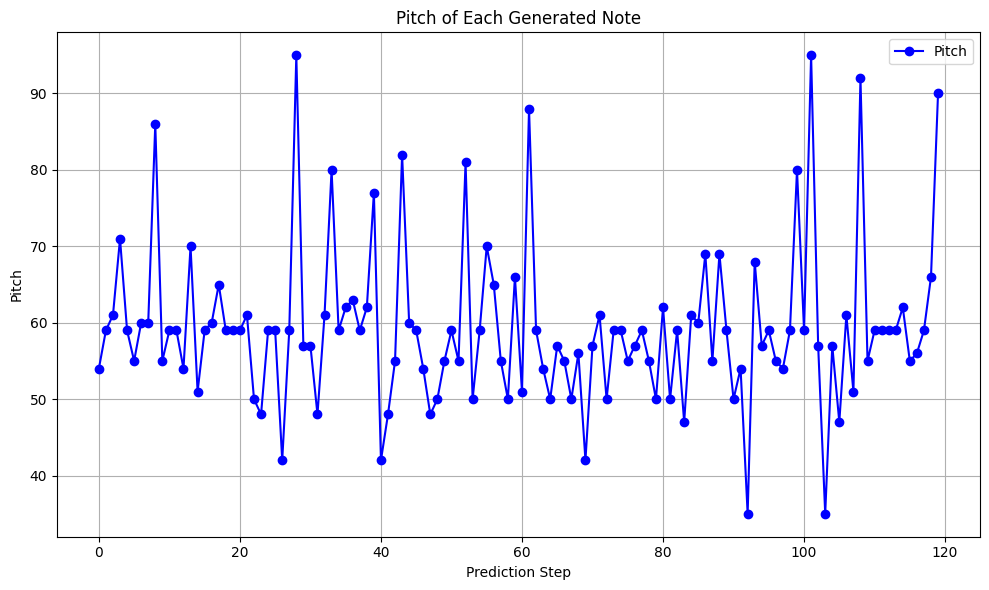

In [41]:
# ค่าพารามิเตอร์เบื้องต้น
temperature = 2.0  # ค่าความสุ่มในการสร้างโน้ต
num_predictions = 120

# ขนาดของ pitch ที่โมเดลรองรับ
vocab_size = 128  # ขนาดของ pitch

# รับค่าจากผู้ใช้
user_input = input("Enter notes (e.g., G2 G1 C3 F3 D4): ")
note_list = user_input.split()  # แยกโน้ตที่ผู้ใช้ป้อน

# การแปลงโน้ตเป็นค่า pitch
def note_to_pitch(note):
    pitch_map = {
        'C': 60, 'C#': 61, 'D': 62, 'D#': 63, 'E': 64, 'F': 65, 'F#': 66,
        'G': 67, 'G#': 68, 'A': 69, 'A#': 70, 'B': 71
    }
    if len(note) > 2 and note[1] == '#':
        base_note = note[:-1]  # Exclude the octave number
    else:
        base_note = note[:-1]
    
    octave = int(note[-1])
    return pitch_map[base_note] + (octave - 4) * 12  # Assume octave 4 as the middle octave

# แปลงโน้ตเป็น pitch
pitches = [note_to_pitch(note) for note in note_list]

# สร้าง input_notes
seq_length = len(pitches)  # ความยาวลำดับโน้ตเริ่มต้น
input_notes = np.zeros((seq_length, 3))  # สร้าง array สำหรับ input notes
input_notes[:, 0] = pitches  # เก็บ pitch ใน input_notes
input_notes[:, 1] = 1  # กำหนดค่า step เป็น 1 สำหรับทุกโน้ต
input_notes[:, 2] = 1  # กำหนดค่า duration เป็น 1 สำหรับทุกโน้ต

generated_notes = []
steps = []    # เก็บ step ของโน้ตที่โมเดลสร้าง
durations = []  # เก็บ duration ของโน้ตที่โมเดลสร้าง

prev_start = 0

# ลูปการคาดเดาโน้ต
for i in range(num_predictions):
    # คำนวณโน้ตถัดไปโดยโมเดล
    pitch, step, duration = predict_next_note(input_notes, keras_model=model, temperature=temperature)
    
    # ปรับให้ step และ duration เท่ากัน
    step = duration  # บังคับให้ค่า step และ duration เท่ากัน

    # คำนวณโน้ตเริ่มต้นและสิ้นสุด
    start = prev_start + step
    end = start + duration
    generated_note = (pitch, step, duration, start, end)
    
    # เก็บข้อมูลของ pitch, step, และ duration
    pitches.append(pitch)
    steps.append(step)
    durations.append(duration)
    
    # เก็บโน้ตที่สร้างขึ้น
    generated_notes.append(generated_note)

    # อัปเดต input_notes โดยใช้โน้ตที่โมเดลพยากรณ์
    input_notes = np.delete(input_notes, 0, axis=0)  # ลบโน้ตแรกออก
    input_notes = np.append(input_notes, np.array([[pitch, step, duration]]), axis=0)  # เพิ่มโน้ตที่พยากรณ์ได้ลงใน input

    prev_start = start

# สร้าง DataFrame จากโน้ตที่สร้างขึ้น
generated_notes_df = pd.DataFrame(
    generated_notes, columns=('pitch', 'step', 'duration', 'start', 'end'))


# วาดกราฟแสดงเฉพาะ pitch
fig, ax = plt.subplots(figsize=(10, 6))

# กราฟ pitch
ax.plot(range(num_predictions), [note[0] for note in generated_notes], label="Pitch", marker='o', color='b')
ax.set_title("Pitch of Each Generated Note")
ax.set_xlabel("Prediction Step")
ax.set_ylabel("Pitch")
ax.legend()
ax.grid(True)

# แสดงกราฟ
plt.tight_layout()
plt.show()



แสดงพล็อตโน้ตทั้งเพลง

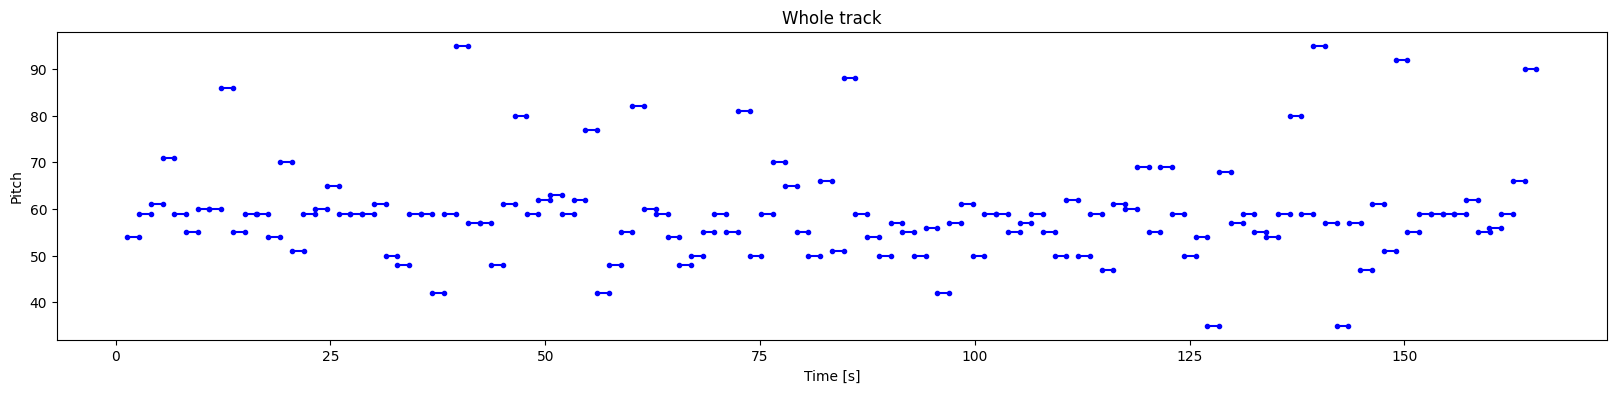

In [43]:
# แสดงพล็อตโน้ตทั้งเพลง
plot_piano_roll(generated_notes_df)

แสดง 10 แถวบนสุด

In [44]:
generated_notes_df.head(10)

,pitch,step,duration,start,end
0,54,1.356482,1.356482,1.356482,2.712965
1,59,1.363865,1.363865,2.720347,4.084212
2,61,1.365491,1.365491,4.085838,5.451329
3,71,1.366153,1.366153,5.451990,6.818143
4,59,1.371358,1.371358,6.823349,8.194707
5,55,1.364898,1.364898,8.188247,9.553146
6,60,1.363869,1.363869,9.552116,10.915986
7,60,1.365892,1.365892,10.918008,12.283900
8,86,1.365649,1.365649,12.283657,13.649306
9,55,1.378540,1.378540,13.662197,15.040736


# ฟังก์ชันแปลงโน้ตเป็นไฟล์ MIDI

ในส่วนนี้ เราจะสร้างฟังก์ชันที่ช่วยในการแปลงโน้ตที่สร้างขึ้นเป็นไฟล์ MIDI โดยใช้ไลบรารี `pretty_midi` ซึ่งเป็นเครื่องมือที่สะดวกสำหรับการจัดการไฟล์ MIDI ใน Python

## ฟังก์ชัน `notes_to_midi`

ฟังก์ชันนี้รับพารามิเตอร์ต่าง ๆ ได้แก่:
- `notes`: รายการของโน้ตที่ต้องการแปลง โดยแต่ละโน้ตจะต้องเป็น tuple ที่มีค่าต่อไปนี้: 
  - `pitch`: ความสูงของโน้ต
  - `step`: ขั้นตอน (step) ที่โน้ตเริ่มต้น
  - `duration`: ระยะเวลา (duration) ของโน้ต
  - `start`: เวลาเริ่มต้น (start) ของโน้ต
  - `end`: เวลาสิ้นสุด (end) ของโน้ต
- `out_file`: ชื่อไฟล์ MIDI ที่ต้องการบันทึก
- `instrument_name`: ชื่อเครื่องดนตรีที่ใช้ใน MIDI
- `velocity`: ความดัง (velocity) ของโน้ต (ค่าเริ่มต้นคือ 100)


In [46]:
import pretty_midi

# ฟังก์ชันแปลงโน้ตเป็นไฟล์ MIDI
def notes_to_midi(notes: list, out_file: str, instrument_name: str, velocity: int = 100) -> pretty_midi.PrettyMIDI:
    pm = pretty_midi.PrettyMIDI()
    # สร้างเครื่องดนตรีที่ใช้ใน MIDI
    instrument = pretty_midi.Instrument(program=pretty_midi.instrument_name_to_program(instrument_name))

    prev_start = 0
    for note in notes:  # notes เป็น list ของ tuples (pitch, step, duration, start, end)
        pitch, step, duration, start, end = note
        midi_start = float(prev_start + step)
        midi_end = float(midi_start + duration)
        midi_note = pretty_midi.Note(velocity=velocity, pitch=int(pitch), start=midi_start, end=midi_end)
        instrument.notes.append(midi_note)
        prev_start = midi_start

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm

# กำหนดชื่อไฟล์ MIDI และเครื่องดนตรีที่ต้องการใช้
out_file = 'generated_music.mid'
instrument_name = 'Acoustic Grand Piano'  # ตัวอย่างเช่น 'Acoustic Grand Piano'

# เรียกใช้ฟังก์ชันกับ list generated_notes
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)

print(f"MIDI file has been saved as {out_file}")


MIDI file has been saved as generated_music.mid


# การบันทึกโมเดล Keras

ในส่วนนี้เราจะแสดงวิธีการบันทึกโมเดลที่สร้างขึ้นโดยใช้ Keras ลงในไฟล์ HDF5 ซึ่งจะช่วยให้เราสามารถนำโมเดลนี้ไปใช้ใหม่ในอนาคตโดยไม่ต้องฝึกโมเดลใหม่อีกครั้ง
เราสามารถบันทึกโมเดลด้วยการใช้ฟังก์ชัน `save()` ของ Keras และระบุเส้นทางที่ต้องการเก็บไฟล์โมเดล 

In [38]:
model_save_path = './saved_model/mymodel50.h5'
model.save(model_save_path)

print(f'Model saved at: {model_save_path}')


Model saved at: ./saved_model/mymodel50.h5
